## **Weather Classification using VGG19** 

This project is done using Kaggle's GPU

- ### **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
import tqdm as tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model

import os


2024-02-21 07:12:53.251654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 07:12:53.251783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 07:12:53.385040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

- ### **Dataset Loading**

This dataset is imported directly from Kaggle, here's the dataset https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/multiclass-weather-dataset/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/multiclass-weather-dataset/dataset/test.csv
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy88.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy167.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy78.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy80.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy2.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy89.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy99.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy256.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy9.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy185.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy208.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy44.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy269.jpg
/kaggle/input/multiclass-weather-dataset/d

In [ ]:
root_dir = "/content/drive/MyDrive/Data Science/Computer Vision/Weather_Dataset"
os.listdir(root_dir)

['test.csv', 'alien_test', 'cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [5]:
foggy = '/kaggle/input/multiclass-weather-dataset/dataset/foggy'
rainy = '/kaggle/input/multiclass-weather-dataset/dataset/rainy'
sunrise = '/kaggle/input/multiclass-weather-dataset/dataset/sunrise'
cloudy = '/kaggle/input/multiclass-weather-dataset/dataset/cloudy'
shine = '/kaggle/input/multiclass-weather-dataset/dataset/shine'
test = '/kaggle/input/multiclass-weather-dataset/dataset/alien_test'

print("Number of Images in Each Directory:")
print(f"Foggy: {len(os.listdir(foggy))}")
print(f"Sunrise: {len(os.listdir(sunrise))}")
print(f"Shine: {len(os.listdir(shine))}")
print(f"Rainy: {len(os.listdir(rainy))}")
print(f"Cloudy: {len(os.listdir(cloudy))}")

Number of Images in Each Directory:
Foggy: 300
Sunrise: 350
Shine: 250
Rainy: 300
Cloudy: 300


Here we divided the datasets into 5 directories

In [6]:
x = []
y = []
dataset = []

def create_dataset(directory, dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory, i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img, (150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [7]:
x,y = create_dataset(foggy, "foggy")
x,y = create_dataset(sunrise, "sunrise")
x,y = create_dataset(shine, "shine")
x,y = create_dataset(cloudy, "cloudy")
x,y = create_dataset(rainy, "rainy")


100%|██████████| 300/300 [00:05<00:00, 54.13it/s]


In [8]:
x = np.array(x)
y = np.array(y)

x.shape, y.shape

((1498, 150, 150, 3), (1498,))

- ### **Plotting Images**

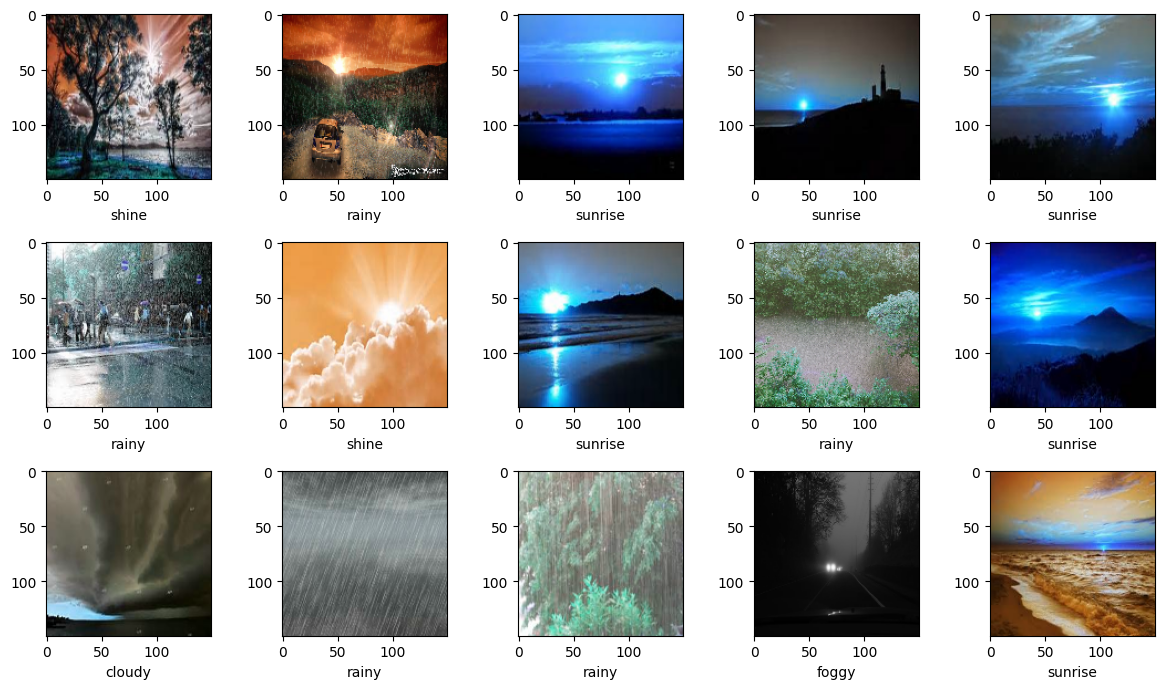

In [9]:
import random

fig = plt.figure(figsize=(12,7))

for i in range(15):
    sample = random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]

    plt.subplot(3,5, i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image)
    plt.xlabel(category)

plt.tight_layout()
plt.show()

- ### **Train Test Split**

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

This dataset is divided into 80 20 ratio for Train Test and Validation sets

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

- ### **Data Augmentation** 

In [12]:
img_size = 150

# Rescaling the train and test dataset
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

# Reshaping Train and Test dataset
x_train= x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)


In [13]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)
y_train_lb.shape,y_test_lb.shape

((1198, 5), (300, 5))

### **Model Buidling and Training (VGG19)**

We used Keras's VGG19 Model that is pre-trained on the ImageNet Dataset, and we'll be using ImageNet's weights 

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(weights="imagenet", include_top=False, input_shape=(img_size,img_size,3))

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
# Freeze the model's pre-trained layers

for layer in vgg.layers:
    layer.trainable = False

In [16]:
# Customize the Last Prediction layers according to our dataset

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()

model.add(vgg)
model.add(Flatten())
model.add(Dense(5, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 20065349 (76.54 MB)
Trainable params: 40965 (160.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [17]:
# Save the model
model.save("weather_model.h5")

In [18]:
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics="accuracy")

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "weathe_model.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False)

earlystop = EarlyStopping(monitor = "val_accuracy", patience = 5, verbose = 1)

- Compiles a neural network model with the Adam optimizer and categorical cross-entropy loss function.
- Defines callbacks:
  - `ModelCheckpoint` to save the best model weights based on validation accuracy.
  - `EarlyStopping` to stop training early if the validation accuracy does not improve after a specified number of epochs.


In [19]:
unique, counts = np.unique(y_train, return_counts = True)
print(unique, counts)

[0 1 2 3 4] [229 244 239 204 282]


- ### **Model Training**

In [20]:
batch_size = 32

history = model.fit(
    x_train,
    y_train_lb,
    epochs = 15,
    validation_data = (x_test, y_test_lb),
    batch_size = batch_size,
    verbose = 1,
    callbacks = [checkpoint, earlystop]
)

Epoch 1/15
 1/38 [..............................] - ETA: 4:31 - loss: 1.6921 - accuracy: 0.1562

I0000 00:00:1708499946.286733     192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.6219
Epoch 1: val_accuracy improved from -inf to 0.87000, saving model to weathe_model.h5
38/38 [==============================] - 16s 244ms/step - loss: 0.9975 - accuracy: 0.6219 - val_loss: 0.4772 - val_accuracy: 0.8700
Epoch 2/15
37/38 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.8421
Epoch 2: val_accuracy improved from 0.87000 to 0.92333, saving model to weathe_model.h5
38/38 [==============================] - 4s 103ms/step - loss: 0.4725 - accuracy: 0.8422 - val_loss: 0.3467 - val_accuracy: 0.9233
Epoch 3/15
37/38 [============================>.] - ETA: 0s - loss: 0.3439 - accuracy: 0.9046
Epoch 3: val_accuracy did not improve from 0.92333
38/38 [==============================] - 4s 97ms/step - loss: 0.3432 - accuracy: 0.9040 - val_loss: 0.3031 - val_accuracy: 0.9167
Epoch 4/15
37/38 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.9341
Epoch 4: val_accur

- **Epochs**: The training process is repeated for 15 epochs, meaning the entire dataset is processed 15 times.
- **Training Progress**: For each epoch, it shows the progress of training batches through the dataset. For example, "1/38" indicates the first batch out of 38 batches for that epoch.
- **Loss and Accuracy**: It displays the loss and accuracy values for both training (`loss`, `accuracy`) and validation (`val_loss`, `val_accuracy`) datasets. These metrics indicate how well the model is performing on both the training data and unseen validation data.
- **Validation Improvement**: The "val_accuracy" improved from epoch to epoch, reaching a maximum of 0.94 (94%) at epoch 13.
- **Model Saving**: Whenever the validation accuracy improves, it saves the model's weights to a file named "weathe_model.h5".
- **Early Stopping**: The training process stopped early at epoch 13 as there was no improvement in validation accuracy for a certain number of epochs, as specified by the `EarlyStopping` callback.

Overall, this output provides insights into the training process, including performance metrics and whether the model is improving or if training should be stopped early to prevent overfitting.

In [21]:
loss, accuracy = model.evaluate(x_test, y_test_lb)

print(f"Loss: {loss*100}")
print(f"Accuracy: {accuracy*100}")

10/10 [==============================] - 1s 78ms/step - loss: 0.2131 - accuracy: 0.9367
Loss: 21.309955418109894
Accuracy: 93.66666674613953


- The loss on the test dataset is approximately 21.31%.
- The accuracy on the test dataset is approximately 93.67%.

In [22]:
y_pred = model.predict(x_test)

10/10 [==============================] - 1s 83ms/step


In [23]:
y_pred_class = np.argmax(y_pred, axis = 1)

In [24]:
y_pred_class

array([0, 2, 2, 2, 3, 1, 0, 3, 4, 1, 3, 0, 2, 2, 1, 1, 3, 0, 4, 1, 4, 4,
       1, 1, 4, 4, 2, 2, 2, 3, 1, 4, 3, 2, 0, 3, 3, 4, 4, 4, 4, 3, 0, 2,
       2, 4, 0, 4, 4, 0, 0, 0, 4, 0, 4, 3, 1, 2, 1, 2, 0, 0, 2, 1, 3, 4,
       4, 2, 2, 2, 0, 0, 4, 4, 3, 4, 4, 4, 3, 4, 0, 1, 1, 3, 1, 1, 0, 2,
       3, 4, 0, 4, 0, 0, 3, 0, 4, 1, 4, 0, 1, 3, 3, 3, 2, 1, 3, 1, 1, 4,
       4, 2, 0, 4, 1, 4, 3, 2, 2, 0, 3, 4, 3, 4, 1, 0, 3, 3, 3, 1, 1, 1,
       4, 0, 4, 1, 0, 4, 0, 1, 4, 1, 2, 0, 1, 4, 4, 2, 3, 2, 0, 1, 4, 4,
       3, 2, 4, 3, 1, 4, 0, 1, 4, 1, 1, 4, 2, 4, 4, 4, 0, 4, 0, 2, 3, 4,
       0, 4, 3, 1, 0, 2, 1, 3, 3, 0, 2, 4, 4, 1, 2, 2, 2, 2, 1, 2, 1, 1,
       0, 0, 0, 4, 2, 0, 0, 1, 0, 4, 4, 1, 3, 0, 0, 0, 2, 4, 3, 2, 1, 1,
       2, 0, 0, 1, 2, 1, 1, 2, 2, 4, 3, 0, 4, 0, 3, 2, 2, 2, 3, 4, 3, 0,
       1, 3, 3, 0, 2, 0, 4, 0, 3, 3, 0, 4, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 4, 1, 4, 0, 1, 1, 4, 3, 0, 3, 3, 2, 0, 0, 4, 2, 4, 2, 1, 0, 1,
       2, 1, 2, 3, 2, 1, 2, 2, 1, 4, 2, 0, 2, 4])

- ### **Classification Report**

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        71
           1       0.91      0.93      0.92        56
           2       0.97      0.95      0.96        60
           3       0.87      0.91      0.89        45
           4       0.94      0.97      0.96        68

    accuracy                           0.94       300
   macro avg       0.93      0.94      0.93       300
weighted avg       0.94      0.94      0.94       300



  The model achieved an overall accuracy of 94% on the test dataset.
- For each class:
  - Class 0: 97% precision, 92% recall, and 94% F1-score.
  - Class 1: 91% precision, 93% recall, and 92% F1-score.
  - Class 2: 97% precision, 95% recall, and 96% F1-score.
  - Class 3: 87% precision, 91% recall, and 89% F1-score.
  - Class 4: 94% precision, 97% recall, and 96% F1-score.
- The macro average of precision, recall, and F1-score is 93%.
- The weighted average of precision, recall, and F1-score is also 94%.
- Each metric provides insights into the model's performance for each class and overall.


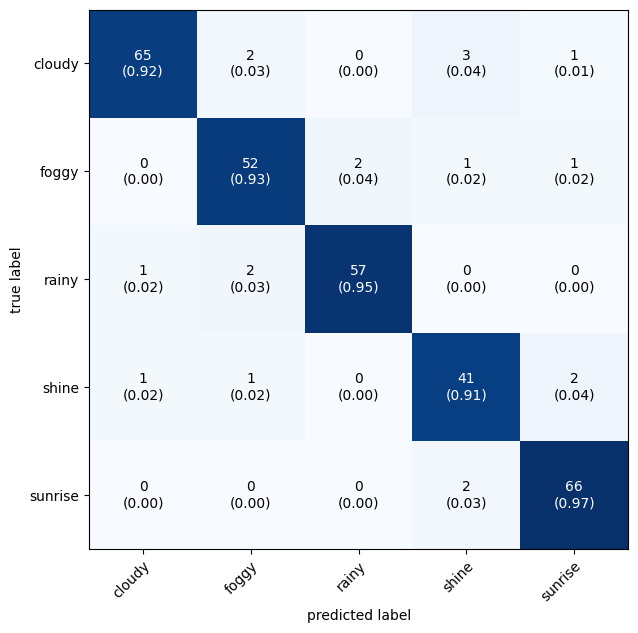

In [27]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred_class)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cloudy","foggy","rainy","shine","sunrise"],
                      show_normed = True);

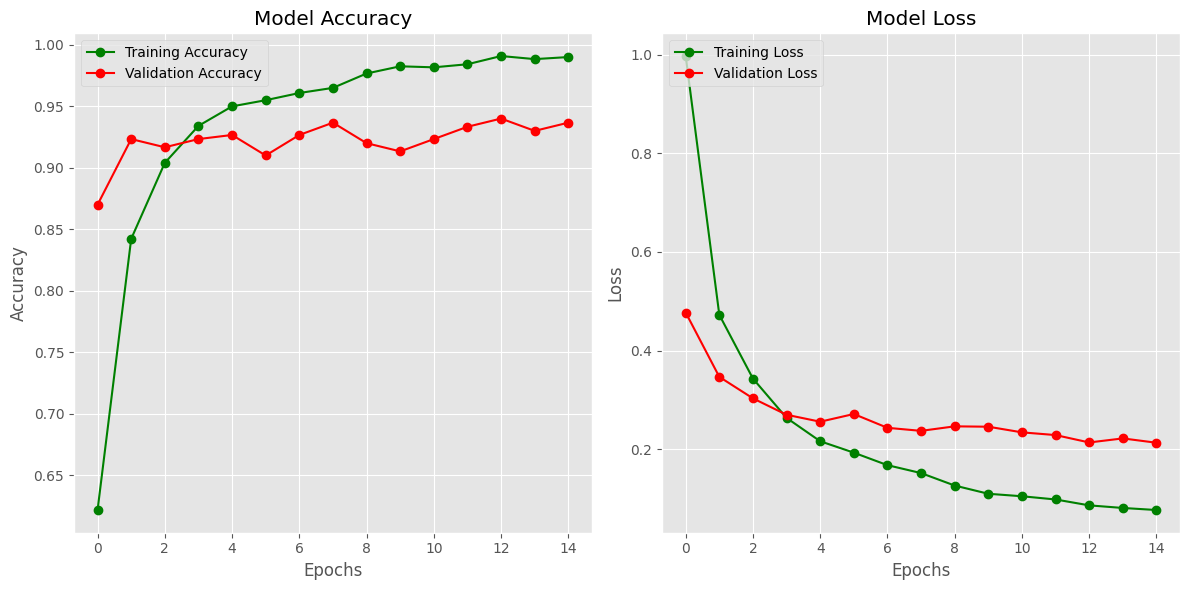

In [28]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.style.use("ggplot")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Accuracy plot
axes[0].plot(history.epoch, history.history['accuracy'], 'go-', label='Training Accuracy')
axes[0].plot(history.epoch, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper left')

# Loss plot
axes[1].plot(history.epoch, history.history['loss'], 'go-', label='Training Loss')
axes[1].plot(history.epoch, history.history['val_loss'], 'ro-', label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

Here's the interpretation of the model accuracy and loss 

- **Model Accuracy**:
  - *Training Accuracy*: Increases sharply initially, then plateaus, indicating learning from training data.
  - *Validation Accuracy*: Follows a similar pattern but slightly lower, representing performance on unseen data.
  
- **Model Loss**:
  - *Training Loss*: Decreases sharply initially, then flattens out, showing improvement in performance on training data.
  - *Validation Loss*: Follows a similar trend to training loss but slightly higher, indicating performance on validation data.

- **Interpretation**:
  - The model demonstrates learning with increasing accuracy and decreasing loss.
  - Early epochs show rapid improvement which gradually slows down.
  - Training accuracy is typically higher than validation accuracy, suggesting model optimization for training data.
  - Higher validation loss compared to training loss may indicate potential overfitting or increased difficulty in validation data.
  - Further training may not significantly benefit the model beyond a certain point, indicated by plateauing in performance metrics.
  - The small gap between training and validation performance suggests good generalization of the model.
